1.) Imports

In [22]:
#Import required libraries
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import gaussian_kde

2.) Working Directory

In [24]:
#Check the current working directory
print("Current working directory:", os.getcwd())

#Set the working directory
os.chdir('C:/Users/ambue/OneDrive/Documents/Working_Directory')  #Replace with your own desired path
print("New working directory:", os.getcwd())

Current working directory: C:\Users\ambue
New working directory: C:\Users\ambue\OneDrive\Documents\Working_Directory


3.) Load and Preprocess Data

In [26]:
# Set file path
file_path = r"C:\Users\ambue\OneDrive\Documents\Working_Directory\Analysis_Data.xlsx"

#Load the dataset
df_all = pd.read_excel(file_path, sheet_name='Drilling Cost', skiprows=2)

#Remove 2007 row if present
df_all = df_all[:-1].replace('.', np.nan)

#Convert date to datetime
df_all['Date'] = pd.to_datetime(df_all['Date'], errors='coerce')

#Calculate correct average cost
df_all['avg cost'] = df_all.iloc[:, 1:4].astype(float).mean(axis=1)

#Filter for 1990-2006 using June 30th as the cutoff
df_sub = df_all[(df_all['Date'] > pd.Timestamp('1990-06-30')) & (df_all['Date'] <= pd.Timestamp('2006-06-30'))]

#Convert returns to float
return_columns = ['Arithmetic Return - Crude Oil', 'Arithmetic Return - Natural Gas', 'Arithmetic Return - Dry Well']
df_sub[return_columns] = df_sub[return_columns].astype(float)

#Reshape to long format for KDE estimation
df_sub = df_sub.melt(id_vars='Date', value_vars=return_columns, var_name="Commodity", value_name="Return_Pct")

#Display summary statistics
print("Mean Return:", df_sub['Return_Pct'].mean())
print("Std Dev Return:", df_sub['Return_Pct'].std())

Mean Return: 0.13149126581580003
Std Dev Return: 0.17843720001183144


C:\Users\ambue\AppData\Local\Temp\ipykernel_33204\35600564.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub[return_columns] = df_sub[return_columns].astype(float)


4.) Q-Q Plot to Assess Normality

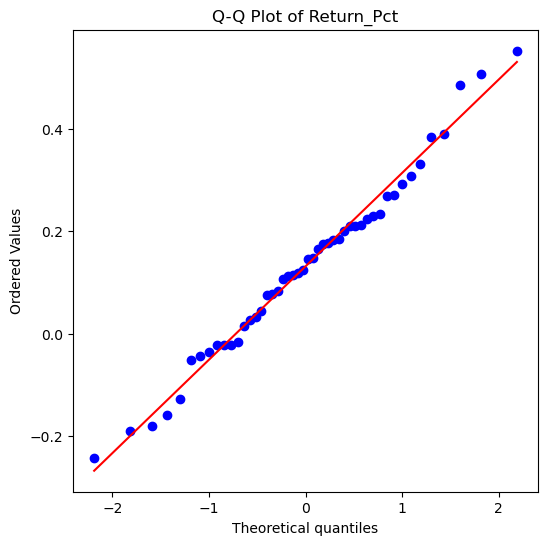

In [28]:
#Q-Q Plot for normality check
fig, ax = plt.subplots(figsize=(6, 6))
stats.probplot(df_sub['Return_Pct'].dropna(), dist="norm", plot=ax)
ax.set_title("Q-Q Plot of Return_Pct")
plt.show()

5.) Histogram to Assess Distribution

C:\Users\ambue\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


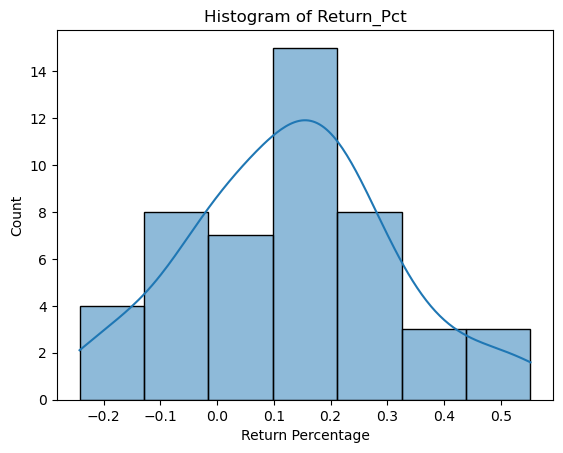

In [30]:
#Histogram for returns
sns.histplot(df_sub['Return_Pct'], kde=True)
plt.xlabel("Return Percentage")
plt.title("Histogram of Return_Pct")
plt.show()

6.) Statistical Test for Normality

In [32]:
#Perform Shapiro-Wilk test for normality
shapiro_test = stats.shapiro(df_sub['Return_Pct'].dropna())
print("Shapiro-Wilk Test Statistic:", shapiro_test.statistic)
print("Shapiro-Wilk p-value:", shapiro_test.pvalue)

Shapiro-Wilk Test Statistic: 0.9853198528289795
Shapiro-Wilk p-value: 0.804128110408783


7.)  Set Up for Simulations

In [34]:
#Get the correct starting cost (2006 value)
P0 = df_all[df_all['Date'] == pd.Timestamp('2006-06-30')]['avg cost'].values[0]

#Set seed for reproducibility
np.random.seed(2377)
num_simulations = 10000

8.) Simulation under Normality Assumption

In [ ]:
data_norm = []

for _ in range(num_simulations):
    Pt = P0  # Initialize cost

    #2006-2012: Simulate based on Normal distribution
    for _ in range(5):
        ret = np.random.normal(loc=df_sub['Return_Pct'].mean(), scale=df_sub['Return_Pct'].std())
        Pt *= (1 + ret)

    #2012-2015: Costs decrease (Triangular Distribution)
    for _ in range(3):
        ret = np.random.triangular(left=-0.22, mode=-0.1314875, right=-0.07)
        Pt *= (1 + ret)

    #2015-2024: Costs increase (Triangular Distribution)
    for _ in range(10):
        ret = np.random.triangular(left=0.02, mode=0.05, right=0.06)
        Pt *= (1 + ret)

    data_norm.append(Pt)

#Convert normal simulation results to DataFrame
df_2025_norm = pd.DataFrame(data_norm, columns=["Final_Cost"])

#Plot histogram for normal distribution simulation
plt.hist(df_2025_norm["Final_Cost"], bins=50, alpha=0.75, color="skyblue", edgecolor="black")
plt.xlabel("Final Drilling Cost (2025)")
plt.ylabel("Frequency")
plt.title("Simulated 2025 Drilling Costs (Normal Distribution)")
plt.show()

#Mean estimate under normal distribution
print("Mean Estimate (Normal):", df_2025_norm["Final_Cost"].mean())

9.) Simulation using Kernel Density Estimate 

In [ ]:
#Fit KDE on the correct dataset
kernel = gaussian_kde(df_sub['Return_Pct'].dropna())

data_kde = []

for _ in range(num_simulations):
    Pt = P0  # Initialize cost

    #2006-2012: Simulate using KDE-based returns
    for _ in range(5):  
        ret = kernel.resample(size=1).item()
        Pt *= (1 + ret)

    #2012-2015: Costs decrease (Triangular Distribution)
    for _ in range(3):
        ret = np.random.triangular(left=-0.22, mode=-0.1314875, right=-0.07)
        Pt *= (1 + ret)

    #2015-2024: Costs increase (Triangular Distribution)
    for _ in range(10):
        ret = np.random.triangular(left=0.02, mode=0.05, right=0.06)
        Pt *= (1 + ret)

    data_kde.append(Pt)

#Convert KDE simulation results to DataFrame
df_2025_kde = pd.DataFrame(data_kde, columns=["Final_Cost"])

#Plot histogram for KDE-based simulation
plt.hist(df_2025_kde["Final_Cost"], bins=50, alpha=0.75, color="b", edgecolor="black")
plt.xlabel("Final Drilling Cost (2025)")
plt.ylabel("Frequency")
plt.title("Simulated 2025 Drilling Costs (KDE-Based)")
plt.show()

#Mean estimate under KDE-based simulation
print("Mean Estimate (KDE):", df_2025_kde["Final_Cost"].mean())